# Analysis of SEIRX model runs for test technology and screening frequency

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Utility functions for plotting

In [16]:
def get_image(df, metric):
    vaccination_rates = ['100 %','90 %','80 %','70 %','60 %','50 %','40 %',
                           '30 %','20 %','10 %','0 %']
    img = np.zeros((len(vaccination_rates), len(vaccination_rates)))
    for i, p_index in enumerate(vaccination_rates):
        for j, e_index in enumerate(vaccination_rates):
            img[i, j] = df.loc[p_index, e_index][metric]
    return img

def plot_heatmap_turnover_time(ax, img, vmin, vmax, xticks, yticks):
    cmap = plt.get_cmap('coolwarm')
    im = ax.imshow(img, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)
    
    if xticks:
        ax.set_xticks(range(len(screening_intervals)))
        ax.set_xticklabels(screening_intervals, fontsize=9)
        ax.set_xlabel('vaccinated employees', fontsize=12)
    else:
        ax.set_xticks([])
    if yticks:    
        ax.set_yticks(range(len(screening_intervals)))
        ax.set_yticklabels(screening_intervals, fontsize=9)
        ax.set_ylabel('vaccinated residents', fontsize=12)
    else:
        ax.set_yticks([])
    
    return im

def annotate_heatmap(ax, img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            y_pos = i - 0.05
            x_pos = j - 0.15
            ax.text(x_pos, y_pos, '{:1.2f}'.format(img[i, j]))

### Mappings of variables to nicer labels for plots

In [4]:
frequency_name_map = {
              1.0:'100 %',
              0.9:'90 %',
              0.8:'80 %',
              0.7:'70 %',
              0.6:'60 %',
              0.5:'50 %',
              0.4:'40 %',
              0.3:'30 %',
              0.2:'20 %',
              0.1:'10 %',
              0.0:'0 %'}

metric_name_map = {'infected_residents_mean':'follow-up cases residents (mean)',
                   'infected_residents_median':'follow-up cases residends (median)',
                   'infected_residents_0.90':'follow-up cases residents (90th percentile)',
                   'R0_mean':'$R_0$',
                   'R0_mean':'$R_0$'}

index_case_map = {'employee':'index case employee',
                  'resident':'index case resident'}

screening_intervals = ['100 %','90 %','80 %','70 %','60 %','50 %','40 %',
                           '30 %','20 %','10 %','0 %']

### Data loading and wrangling

In [5]:
res_path = '../data/simulation_results'
dst_path = '../plots'
sim_name = 'simulations_vaccination_rate'
data = pd.read_csv(join(res_path,'{}.csv'.format(sim_name)))

In [6]:
# replace strings with strings that are nicer for plotting
data['resident_vaccination_probability'] = data['resident_vaccination_probability']\
    .replace(frequency_name_map)
data['employee_vaccination_probability'] = data['employee_vaccination_probability']\
    .replace(frequency_name_map)

# set a multi-index to facilitate access to different scenarios that were simulated
tuples = [(r['resident_vaccination_probability'],\
           r['employee_vaccination_probability']) for i,r in data.iterrows()]
index = pd.MultiIndex.from_tuples(tuples,\
    names=['resident_vaccination_probability', 'employee_vaccination_probability'])
data = data.set_index(index)

## Different test technologies

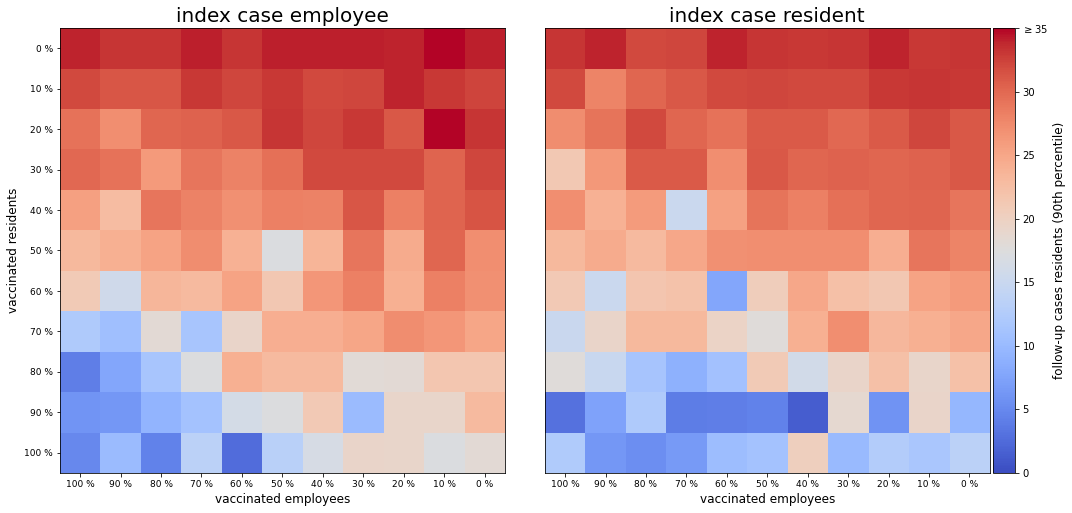

In [40]:
metric = 'infected_residents_0.90'
sim_name = 'simulation_results'

# figure layout & axis setup
fig, axes = plt.subplots(1, 2, figsize=(15, 9))

vmin=0
vmax=35
vstep=5

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode, ax in zip([0, 1], ['employee', 'resident'], axes):
    df = data[data['index_case'] == index_case_mode]
    
    ax.set_title(index_case_map[index_case_mode], fontsize=20)
        
    # set flag to set axis ticks only for heatmaps at the boundaries of 
    # the figure
    xticks = True
    yticks = False
    if i == 0:
        yticks = True

    # plot heatmap of the scenario
    img = get_image(df, metric)
    if index_case_mode == 'resident':
        # if a resident is the index case, we need to subtract 1 from the
        # number of infected residents, to calculate the "outbreak size",
        # which is defined as the number of FOLLOW-UP cases, given an index
        # case
        img = img - 1
    img_plot = plot_heatmap_turnover_time(ax,img,vmin,vmax,xticks,yticks)
        
# colorbar
divider = make_axes_locatable(axes[1])
cbar_ax = divider.append_axes('right', size='5%', pad=0.05)

norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                        ticks=np.arange(vmin, vmax + 1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

# dummy axis to preserve spacing
divider = make_axes_locatable(axes[0])
cbar_ax = divider.append_axes('right', size='5%', pad=0.05)
cbar_ax.set_axis_off()

plt.tight_layout()